In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install lime
!pip install shap
!pip install innvestigate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=6cfcb6fcc156048f4447e7d70cb97403c04349dc59747d7b36ba82a607095420
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.9/840.9 kB 9.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 489.9/489.9 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 44.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 47.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 85.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 24.1 MB/s eta 0:00:00
   ━

In [1]:
import os
os.chdir("/content/drive/MyDrive/WORK/Meta_Explainer/Meta-Explainer")
import sys
sys.path.append('/content/drive/MyDrive/WORK/Meta_Explainer/Meta-Explainer')
sys.path

['/content',
 '/env/python',
 '/usr/lib/python311.zip',
 '/usr/lib/python3.11',
 '/usr/lib/python3.11/lib-dynload',
 '',
 '/usr/local/lib/python3.11/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.11/dist-packages/IPython/extensions',
 '/root/.ipython',
 '/content/drive/MyDrive/WORK/Meta_Explainer/Meta-Explainer']

In [19]:
import pickle
import joblib
import openpyxl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import load_model

import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV

tf.compat.v1.disable_eager_execution()
from Tabular.dataset import prepare_breast_cancer_dataset, preprocess_dataset
from Tabular.Relevance.explanations_functions.lime_explainer import lime_explanations,extract_relevances
from Tabular.Relevance.explanations_functions.iNN_explainer import iNN_explanations, extract_iNN_relevances

from Tabular.Relevance import integration_methods
from aux_functions import save_explanations_to_pkl, load_explanations_from_pkl, transform_lse_value, normalize_map
from Metrics.LSE_Analysis import lse_calculate

#Lectura de datos

In [3]:
# Load and prepare the dataset
df, target_col = prepare_breast_cancer_dataset()

# Process the dataset for analysis
df, feature_names, class_values, numeric_columns, rdf, real_feature_names, categorical_columns, features_map = preprocess_dataset(df, target_col)

NUMERIC COLUMNS:
['mean radius', 'mean texture', 'mean perimeter', 'mean area', 'mean smoothness', 'mean compactness', 'mean concavity', 'mean concave points', 'mean symmetry', 'mean fractal dimension', 'radius error', 'texture error', 'perimeter error', 'area error', 'smoothness error', 'compactness error', 'concavity error', 'concave points error', 'symmetry error', 'fractal dimension error', 'worst radius', 'worst texture', 'worst perimeter', 'worst area', 'worst smoothness', 'worst compactness', 'worst concavity', 'worst concave points', 'worst symmetry', 'worst fractal dimension', 'target']
FEATURE NAMES:
['mean radius', 'mean texture', 'mean perimeter', 'mean area', 'mean smoothness', 'mean compactness', 'mean concavity', 'mean concave points', 'mean symmetry', 'mean fractal dimension', 'radius error', 'texture error', 'perimeter error', 'area error', 'smoothness error', 'compactness error', 'concavity error', 'concave points error', 'symmetry error', 'fractal dimension error', '

In [4]:
# Set test size and random state for data splitting
test_size = 0.30
random_state = 0

# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(
    df[feature_names].values,
    df[target_col].values,
    test_size=test_size,
    random_state=random_state,
    stratify=df[target_col].values
)

In [5]:
# Convert Y to One-Hot Encoding format
encoder = OneHotEncoder(sparse_output=False)
Y_train_onehot = encoder.fit_transform(Y_train.reshape(-1, 1))
Y_test_onehot = encoder.transform(Y_test.reshape(-1, 1))

#Lectura del modelo

In [6]:
loaded_model = load_model('Tabular/Model/keras_model.h5')

In [7]:
# Selection and analysis of specific instances
i2e = 2  # First instance to analyze
i2e_2 = 3  # Second instance to analyze (with a different classification)

# Analyze the first instance
x = X_test[i2e]
value = class_value = Y_test[i2e]
print(f"CLASS VALUE FOR INSTANCE {i2e}: {class_value}")

# Predict the class of the first selected instance
model_outcome = loaded_model.predict(x.reshape(1, -1))[0]

# Decode the prediction
predicted_class_index = np.argmax(model_outcome)
print(f'Prediction for black box bb(x) = {model_outcome}')
print(f'Predicted class index: {predicted_class_index}')

# Analyze the second instance
x2 = X_test[i2e_2]
value2 = class_value2 = Y_test[i2e_2]
print(f"\nCLASS VALUE FOR INSTANCE {i2e_2}: {class_value2}")

# Predict the class of the second selected instance
model_outcome2 = loaded_model.predict(x2.reshape(1, -1))[0]

# Decode the prediction
predicted_class_index2 = np.argmax(model_outcome2)
print(f'Prediction for black box bb(x2) = {model_outcome2}')
print(f'Predicted class index: {predicted_class_index2}')

# Set threshold and class index to plot
threshold = 0.75
class_index_to_plot = predicted_class_index

CLASS VALUE FOR INSTANCE 2: 0
Prediction for black box bb(x) = [0.99375397 0.00624608]
Predicted class index: 0

CLASS VALUE FOR INSTANCE 3: 1
Prediction for black box bb(x2) = [0.01471522 0.98528475]
Predicted class index: 1


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


# Individual Explanations

## LIME

In [19]:
#Instance 2
lime_explanations_df_2 = lime_explanations(loaded_model, x, X_train, feature_names, Y_train)
print(lime_explanations_df_2)

# Delet extra shape and features names
lime_explanations_array_2 = extract_relevances(lime_explanations_df_2)
print(lime_explanations_array_2)

[[('677.60 < worst area <= 1080.50', 0.2581475681093653), ('541.70 < mean area <= 782.20', -0.10244942404187442), ('area error > 44.95', 0.09605795619372559), ('perimeter error > 3.28', 0.02835078998668242), ('smoothness error > 0.01', -0.027878313002619663), ('25.23 < worst texture <= 29.61', 0.02586579968386363), ('0.18 < mean symmetry <= 0.20', 0.02406919919499981), ('mean texture > 21.80', -0.022598813645286157), ('concave points error > 0.01', 0.02213561411902754), ('worst smoothness > 0.15', 0.019606764534582287), ('1.13 < texture error <= 1.48', 0.01875437690895139), ('radius error > 0.48', -0.017433335040282754), ('0.28 < worst symmetry <= 0.32', 0.016924663022066584), ('worst fractal dimension > 0.09', 0.01494680341668614), ('0.02 < symmetry error <= 0.02', -0.014595354611355615), ('14.91 < worst radius <= 18.78', 0.013064869780543109), ('worst concavity > 0.38', 0.010597698194672182), ('0.10 < mean smoothness <= 0.11', -0.010119545848652515), ('fractal dimension error > 0.00'

In [20]:
#Instance 3
lime_explanations_df_3 = lime_explanations(loaded_model, x2, X_train, feature_names, Y_train)
print(lime_explanations_df_3)

# Delet extra shape and features names-
lime_explanations_array_3 = extract_relevances(lime_explanations_df_3)
print(lime_explanations_array_3)

[[('505.75 < worst area <= 677.60', -0.22874893033149854), ('408.85 < mean area <= 541.70', -0.055936266989463274), ('symmetry error > 0.02', -0.03407557722472238), ('74.00 < mean perimeter <= 85.91', 0.03233703839006552), ('mean compactness > 0.13', -0.02792650079275187), ('worst fractal dimension > 0.09', 0.027773524736329207), ('compactness error > 0.03', 0.02705748486273724), ('97.59 < worst perimeter <= 124.97', -0.023593546689050827), ('worst concavity > 0.38', -0.017556081150946437), ('concave points error > 0.01', 0.014811433986093324), ('mean symmetry > 0.20', -0.01349828165225617), ('12.84 < worst radius <= 14.91', -0.013395466538193776), ('worst compactness > 0.34', 0.011114908919316917), ('11.55 < mean radius <= 13.23', -0.011008339992155657), ('0.03 < mean concave points <= 0.07', 0.010982975606487557), ('0.12 < worst smoothness <= 0.13', -0.009558330210393817), ('0.01 < smoothness error <= 0.01', -0.007912785431672556), ('0.09 < mean smoothness <= 0.10', -0.00723812202560

## LRP

In [21]:
#Instance 2
lrp_explanations_df_2 = iNN_explanations(loaded_model, x,"lrp.alpha_1_beta_0")

# Delet extra shape
lrp_relevance_array_2 = extract_iNN_relevances(lrp_explanations_df_2)
print(lrp_relevance_array_2)

[[ 5.06191775e-02  6.56152964e-02  2.19814077e-01  7.03384280e-01
   4.46373364e-04  6.10526244e-04  3.92424548e-03  3.09845374e-04
   5.36077656e-04  3.42736574e-04  1.83346681e-02  2.54903990e-03
   3.07467468e-02  1.39631510e-01  3.71655151e-05  2.37233427e-04
   2.04462471e-04  5.58798238e-05  3.04476911e-04  5.78601721e-05
   5.99853955e-02  9.68414173e-02  3.57161045e-01  8.13582122e-01
   5.73984405e-04  4.76060482e-03  3.15574091e-03  8.14151950e-04
   9.83452308e-04  5.10580197e-04]
 [-5.09278364e-02 -6.29452243e-02 -2.05561072e-01 -6.47798419e-01
  -3.80988960e-04 -6.13956654e-04 -2.53892737e-03 -2.93016899e-04
  -5.36870502e-04 -3.02587985e-04 -1.17833149e-02 -2.58254982e-03
  -2.18248796e-02 -1.44828111e-01 -3.35385739e-05 -2.32790044e-04
  -2.14580898e-04 -5.39632274e-05 -1.94421780e-04 -4.07913431e-05
  -5.93018867e-02 -9.31556821e-02 -3.53898942e-01 -8.26820433e-01
  -5.53551654e-04 -3.57880723e-03 -2.86765164e-03 -7.30152009e-04
  -9.41403327e-04 -3.87803826e-04]]


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [22]:
#Instance 3
lrp_explanations_df_3 = iNN_explanations(loaded_model, x2, "lrp.alpha_1_beta_0")

# Delet extra shape
lrp_relevance_array_3 = extract_iNN_relevances(lrp_explanations_df_3)
print(lrp_relevance_array_3)

[[-4.61665317e-02 -4.93019670e-02 -1.84288740e-01 -5.15120625e-01
  -3.95210955e-04 -4.60975716e-04 -2.43379711e-03 -1.67824459e-04
  -5.70589269e-04 -3.31452349e-04 -8.74378905e-03 -2.44145794e-03
  -2.57141665e-02 -7.26726428e-02 -2.74282538e-05 -2.52441503e-04
  -3.29148315e-04 -8.21050926e-05 -5.00984723e-04 -8.06844473e-05
  -4.70203198e-02 -7.08051175e-02 -2.85161078e-01 -5.77833533e-01
  -4.05542931e-04 -2.86526838e-03 -2.16291170e-03 -5.78783045e-04
  -1.14915695e-03 -4.37771349e-04]
 [ 5.80063686e-02  5.62883541e-02  2.13986680e-01  6.10060036e-01
   4.82771255e-04  6.02564774e-04  2.10101553e-03  2.14089625e-04
   6.84542232e-04  4.02260688e-04  7.34418258e-03  3.26971547e-03
   2.41429452e-02  9.40067321e-02  3.42252533e-05  3.40348692e-04
   4.30554443e-04  9.73135102e-05  4.31108405e-04  7.16099094e-05
   6.16738833e-02  8.36960375e-02  3.53419870e-01  7.23923743e-01
   4.79700975e-04  2.78277486e-03  2.70095887e-03  7.32641143e-04
   1.37164898e-03  4.58145281e-04]]


## Integrated Gradients

In [23]:
#Instance 2
ig_explanations_df_2 = iNN_explanations(loaded_model, x,"integrated_gradients")

# Delet extra shape
ig_relevance_array_2 = extract_iNN_relevances(ig_explanations_df_2)
print(ig_relevance_array_2)

[[-1.87293679e-01 -1.01393938e+00 -6.62925434e+00 -1.82039089e+01
  -4.15356015e-04  1.23759955e-02  2.41817664e-02  8.27988610e-03
   2.61607743e-03 -3.22612957e-03 -1.27803916e-02  5.54598458e-02
   9.52057838e-02  2.62138319e+00  2.94714759e-04  6.27592718e-03
   6.34212140e-03  1.05597812e-03  9.22855688e-04  5.17480541e-04
  -9.74459648e-01  1.29084110e+00 -7.16256189e+00  3.63353348e+01
  -3.57868825e-03  7.20748082e-02  9.12101865e-02  1.32197719e-02
   7.58138020e-03  2.43836571e-03]
 [ 1.60551623e-01  8.62841427e-01  6.16113615e+00  1.60811729e+01
  -4.06601524e-04 -1.44036030e-02 -3.21886055e-02 -1.10930065e-02
  -1.93427713e-03  3.88987176e-03  1.50381289e-02 -4.42236438e-02
  -8.33476335e-02 -2.89188170e+00 -1.47583094e-04 -7.69990403e-03
  -5.87262586e-03 -1.51603960e-03 -8.76759645e-04 -4.98141453e-04
   1.14274430e+00 -1.33189738e+00  7.24705362e+00 -3.40906868e+01
   2.98651634e-03 -7.99065828e-02 -8.95523205e-02 -1.51625723e-02
  -1.00763952e-02 -4.05203598e-03]]


In [24]:
#Instance 3
ig_explanations_df_3 = iNN_explanations(loaded_model, x2, "integrated_gradients")

# Delet extra shape
ig_relevance_array_3 = extract_iNN_relevances(ig_explanations_df_3)
print(lrp_relevance_array_3)

[[-4.61665317e-02 -4.93019670e-02 -1.84288740e-01 -5.15120625e-01
  -3.95210955e-04 -4.60975716e-04 -2.43379711e-03 -1.67824459e-04
  -5.70589269e-04 -3.31452349e-04 -8.74378905e-03 -2.44145794e-03
  -2.57141665e-02 -7.26726428e-02 -2.74282538e-05 -2.52441503e-04
  -3.29148315e-04 -8.21050926e-05 -5.00984723e-04 -8.06844473e-05
  -4.70203198e-02 -7.08051175e-02 -2.85161078e-01 -5.77833533e-01
  -4.05542931e-04 -2.86526838e-03 -2.16291170e-03 -5.78783045e-04
  -1.14915695e-03 -4.37771349e-04]
 [ 5.80063686e-02  5.62883541e-02  2.13986680e-01  6.10060036e-01
   4.82771255e-04  6.02564774e-04  2.10101553e-03  2.14089625e-04
   6.84542232e-04  4.02260688e-04  7.34418258e-03  3.26971547e-03
   2.41429452e-02  9.40067321e-02  3.42252533e-05  3.40348692e-04
   4.30554443e-04  9.73135102e-05  4.31108405e-04  7.16099094e-05
   6.16738833e-02  8.36960375e-02  3.53419870e-01  7.23923743e-01
   4.79700975e-04  2.78277486e-03  2.70095887e-03  7.32641143e-04
   1.37164898e-03  4.58145281e-04]]


# Save Explanations

In [8]:
i2=[
    {'explanations': lime_explanations_array_2, 'lse_value':transform_lse_value(lse_calculate(lime_explanations_array_2, predicted_class_index, threshold, "tabular")), 'method':'lime'},
    {'explanations': lrp_relevance_array_2, 'lse_value':transform_lse_value(lse_calculate(lrp_relevance_array_2, predicted_class_index, threshold, "tabular")), 'method': 'lrp'},
    {'explanations': ig_relevance_array_2, 'lse_value':transform_lse_value(lse_calculate(ig_relevance_array_2, predicted_class_index, threshold, "tabular")), 'method': 'integrated gradients'}

]
i3=[
    {'explanations': lime_explanations_array_3, 'lse_value':transform_lse_value(lse_calculate(lime_explanations_array_3, predicted_class_index2, threshold, "tabular")),'method':'lime'},
    {'explanations': lrp_relevance_array_3, 'lse_value':transform_lse_value(lse_calculate(lrp_relevance_array_3, predicted_class_index2, threshold, "tabular")), 'method':'lrp'},
    {'explanations': ig_relevance_array_3, 'lse_value':transform_lse_value(lse_calculate(ig_relevance_array_3, predicted_class_index2, threshold, "tabular")), 'method': 'integrated gradients'}

]

NameError: name 'lime_explanations_array_2' is not defined

In [ ]:
# save_explanations_to_pkl(i2, "Tabular/Relevance/explanations_pkl/instance2_class0.pkl")
# save_explanations_to_pkl(i3, "Tabular/Relevance/explanations_pkl/instance3_class1.pkl")

# Reading Explanations

In [9]:
i2 = load_explanations_from_pkl("Tabular/Relevance/explanations_pkl/instance2_class0.pkl")
i3 = load_explanations_from_pkl("Tabular/Relevance/explanations_pkl/instance3_class1.pkl")

Explanations loaded from Tabular/Relevance/explanations_pkl/instance2_class0.pkl
Explanations loaded from Tabular/Relevance/explanations_pkl/instance3_class1.pkl


In [10]:
# Obtener los mapas de cada método y sus pesos (LSE values)
maps_2 = [data['explanations'] for data in i2]
weights_2 = [data['lse_value'] for data in i2]

maps_3 = [data['explanations'] for data in i3]
weights_3 = [data['lse_value'] for data in i3]

# INTEGRATION

## OWA

In [11]:
# Instance 2
owa_explanation_2 = integration_methods.owa_operator_class_by_class(maps_2, weights_2, method="weighted_average")
owa_lse_value_2 = lse_calculate(owa_explanation_2, predicted_class_index, threshold, 'tabular')

Pesos: [12.5, 8.611132447675356, 12.5]
Normalized Maps: [array([0.63193486, 0.        , 0.36443139, 0.37041093, 0.10729086,
       0.2014802 , 0.20024474, 0.11654795, 0.19480665, 0.19021506,
       0.19821851, 0.12731868, 0.20289351, 0.28675654, 0.13030151,
       0.17883222, 0.17450246, 0.13814477, 0.1730254 , 0.14012256,
       0.1919273 , 0.23534449, 0.27412534, 1.        , 0.16254718,
       0.15278093, 0.15319943, 0.1519899 , 0.15935842, 0.15728646]), array([0.37302079, 1.        , 0.64796006, 0.65858063, 0.89266535,
       0.79929451, 0.80118292, 0.88343495, 0.80594986, 0.81052379,
       0.80616492, 0.87288554, 0.80288407, 0.70734861, 0.86984561,
       0.82174526, 0.82605019, 0.86206663, 0.82757694, 0.86012175,
       0.8127219 , 0.7667214 , 0.74027595, 0.        , 0.83790939,
       0.84805856, 0.8472644 , 0.84836951, 0.84104824, 0.84315492])]
Original shape of relevances: (2, 30)
Valid maps (including zeros for invalid ones): 2
Number of invalid maps: 0
Shape of valid maps: (

In [12]:
# Instance 3
owa_explanation_3 = integration_methods.owa_operator_class_by_class(maps_3, weights_3, method="weighted_average")
owa_lse_value_3 = lse_calculate(owa_explanation_3, predicted_class_index2, 0.75, 'tabular')

Pesos: [12.5, 10.5, 9.789549060919308]
Normalized Maps: [array([0.12877207, 0.96284555, 0.47878095, 0.        , 0.8351322 ,
       1.        , 0.99203616, 0.99419298, 0.99262155, 0.85547038,
       0.85630972, 0.97443031, 0.94058792, 0.80291692, 0.96718951,
       0.96074378, 0.88939373, 0.89801296, 0.94939805, 0.94678172,
       0.88072477, 0.86781756, 0.48227631, 0.67822091, 0.93772138,
       0.91366205, 0.92532212, 0.92181017, 0.92448208, 0.92213863]), array([0.91302228, 0.0286041 , 0.54497412, 1.        , 0.17206654,
       0.        , 0.007267  , 0.00604061, 0.00773859, 0.15087417,
       0.14639593, 0.02730116, 0.0541199 , 0.20695597, 0.03424571,
       0.04098568, 0.11548098, 0.10645325, 0.05261855, 0.05551624,
       0.12578881, 0.13314928, 0.53349976, 0.32751572, 0.06500231,
       0.08923384, 0.07783569, 0.08161624, 0.07870966, 0.08115282])]
Original shape of relevances: (2, 30)
Valid maps (including zeros for invalid ones): 2
Number of invalid maps: 0
Shape of valid maps: (

## Union

In [13]:
# Instance 2
union_explanation_2 = integration_methods.union_operator_class_by_class(maps_2, weights_2, threshold=threshold, operator="sum")
union_lse_value_2 = lse_calculate(union_explanation_2, predicted_class_index, threshold, 'tabular')

Pesos: [12.5, 8.611132447675356, 12.5]
Clase 0: Mapa con 1 rasgos mayores que el umbral (0.75)
Clase 0: Mapa con 2 rasgos mayores que el umbral (0.75)
Clase 0: Mapa con 1 rasgos mayores que el umbral (0.75)
Clase 1: Mapa con 5 rasgos mayores que el umbral (0.75)
Clase 1: Mapa con 27 rasgos mayores que el umbral (0.75)
Clase 1: Mapa con 3 rasgos mayores que el umbral (0.75)
Normalized Maps: [array([0.59210466, 0.        , 0.        , 0.35264432, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 1.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ]), array([0.39504792, 1.        , 0.80656513, 0.61107076, 0.90548591,
       0.42066538, 0.41968528, 0.89658402, 0.42070463, 0.42082391,
       0.41497847, 0.88666483, 0.40986578, 0.34723833, 0.8831534 ,
 

In [14]:
# Instance 3
union_explanation_3 = integration_methods.union_operator_class_by_class(maps_3, weights_3, threshold=threshold, operator="sum")
union_lse_value_3 = lse_calculate(union_explanation_3, predicted_class_index2, threshold, 'tabular')

Pesos: [12.5, 10.5, 9.789549060919308]
Clase 0: Mapa con 29 rasgos mayores que el umbral (0.75)
Clase 0: Mapa con 26 rasgos mayores que el umbral (0.75)
Clase 0: Mapa con 1 rasgos mayores que el umbral (0.75)
Clase 1: Mapa con 1 rasgos mayores que el umbral (0.75)
Clase 1: Mapa con 2 rasgos mayores que el umbral (0.75)
Clase 1: Mapa con 3 rasgos mayores que el umbral (0.75)
Normalized Maps: [array([0.00338102, 0.9578809 , 0.        , 0.00483932, 0.81001406,
       1.        , 0.99050945, 0.99338824, 0.99187771, 0.83356256,
       0.83484701, 0.97066337, 0.93346429, 0.75530515, 0.9623629 ,
       0.95476354, 0.87245528, 0.88250253, 0.94181124, 0.93879475,
       0.87152752, 0.83174869, 0.12476237, 0.87477841, 0.92844815,
       0.89946417, 0.91257727, 0.9097599 , 0.9130085 , 0.91033883]), array([0.6706743 , 0.        , 0.47835346, 1.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,


## Intersección

In [15]:
# Instance 2
intersection_explanation_2 = integration_methods.intersection_operator_class_by_class(maps_2, weights_2, threshold)
intersection_lse_value_2 = lse_calculate(intersection_explanation_2, predicted_class_index, threshold, 'tabular')

Clase 0: 1 elementos en el mapa
Clase 0: 2 elementos en el mapa
Clase 0: 1 elementos en el mapa
Clase 0: 0 elementos Totales intersectados
Clase 1: 5 elementos en el mapa
Clase 1: 27 elementos en el mapa
Clase 1: 3 elementos en el mapa
Clase 1: 0 elementos Totales intersectados
Normalized Maps: [array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])]
Original shape of relevances: (2, 30)
Valid maps (including zeros for invalid ones): 2
Number of invalid maps: 0
Shape of valid maps: (2, 30)
Shape of flattened relevances: (2, 30)
Shape of class relevance: (30,)
Map 0: Max: 0.0, Min: 0.0
Map 1: Max: 0.0, Min: 0.0
Number of features greater than 0.75: 0
Indices greater than 0.75: []
Sum of target class: 0.0
Sum of other classes: 0.0
Calculated IFI: 0



In [16]:
# Instance 3
intersection_explanation_3 = integration_methods.intersection_operator_class_by_class(maps_3, weights_3, threshold)
intersection_lse_value_3 = lse_calculate(intersection_explanation_3, predicted_class_index2, threshold, 'tabular')

Clase 0: 29 elementos en el mapa
Clase 0: 26 elementos en el mapa
Clase 0: 1 elementos en el mapa
Clase 0: 0 elementos Totales intersectados
Clase 1: 1 elementos en el mapa
Clase 1: 2 elementos en el mapa
Clase 1: 3 elementos en el mapa
Clase 1: 0 elementos Totales intersectados
Normalized Maps: [array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])]
Original shape of relevances: (2, 30)
Valid maps (including zeros for invalid ones): 2
Number of invalid maps: 0
Shape of valid maps: (2, 30)
Shape of flattened relevances: (2, 30)
Shape of class relevance: (30,)
Map 0: Max: 0.0, Min: 0.0
Map 1: Max: 0.0, Min: 0.0
Number of features greater than 0.75: 0
Indices greater than 0.75: []
Sum of target class: 0.0
Sum of other classes: 0.0
Calculated IFI: 0



## MAX-MIN-AVG

In [18]:
def max_operator_class_by_class(maps):
    """
    Aplica el operador de máximo para integrar explicaciones tabulares de diferentes métodos por clase.
    Solo se seleccionan los rasgos que superen el umbral.

    Args:
        maps (list of np.ndarray): Lista de matrices de relevancia con dimensiones (n_métodos, n_clases, n_features).

    Returns:
        np.ndarray: Matriz de relevancia integrada por clase con dimensiones (n_clases, n_features).
    """
    num_classes, num_features = np.array(maps[0]).shape
    integrated_maps_per_class = []

    for class_idx in range(num_classes):
        integrated_map = np.zeros(num_features, dtype=np.float64)

        # Normalizar los mapas antes de trabajar con ellos
        normalized_maps = [normalize_map(map_[class_idx]) for map_ in maps]

        # Para cada rasgo, tomamos el valor máximo de todos los mapas de relevancia
        for feature_idx in range(num_features):
            max_value = -np.inf  # Iniciamos con el valor mínimo posible
            # print(f"Clase {class_idx}, Rasgo {feature_idx}: Comparando valores...")

            values = []
            for normalized_map in normalized_maps:
                value = normalized_map[feature_idx]
                values.append(value)
                # print(f"Valor comparado: {value}")

            max_value = max(values)
            integrated_map[feature_idx] = max_value
            # print(f"Seleccionado Max Value = {max_value}")

        integrated_maps_per_class.append(integrated_map)

    return np.array(integrated_maps_per_class)


def min_operator_class_by_class(maps):
    """
    Aplica el operador de mínimo para integrar explicaciones tabulares de diferentes métodos por clase.
    Solo se seleccionan los rasgos más bajos entre todos los métodos.

    Args:
        maps (list of np.ndarray): Lista de matrices de relevancia con dimensiones (n_métodos, n_clases, n_features).

    Returns:
        np.ndarray: Matriz de relevancia integrada por clase con dimensiones (n_clases, n_features).
    """
    num_classes, num_features = np.array(maps[0]).shape
    integrated_maps_per_class = []

    for class_idx in range(num_classes):
        integrated_map = np.zeros(num_features, dtype=np.float64)

        # Normalizar los mapas antes de trabajar con ellos
        normalized_maps = [normalize_map(map_[class_idx]) for map_ in maps]

        # Para cada rasgo, tomamos el valor mínimo de todos los mapas de relevancia
        for feature_idx in range(num_features):
            min_value = np.inf  # Iniciamos con el valor máximo posible
            # print(f"Clase {class_idx}, Rasgo {feature_idx}: Comparando valores...")

            values = []
            for normalized_map in normalized_maps:
                value = normalized_map[feature_idx]
                values.append(value)
                # print(f"Valor comparado: {value}")

            min_value = min(values)
            integrated_map[feature_idx] = min_value
            # print(f"Seleccionado Min Value = {min_value}")

        integrated_maps_per_class.append(integrated_map)

    return np.array(integrated_maps_per_class)


def average_operator_class_by_class(maps):
    """
    Aplica el operador de promedio para integrar explicaciones tabulares de diferentes métodos por clase.
    Solo se seleccionan los rasgos promedios de todos los métodos.

    Args:
        maps (list of np.ndarray): Lista de matrices de relevancia con dimensiones (n_métodos, n_clases, n_features).

    Returns:
        np.ndarray: Matriz de relevancia integrada por clase con dimensiones (n_clases, n_features).
    """
    num_classes, num_features = np.array(maps[0]).shape
    integrated_maps_per_class = []

    for class_idx in range(num_classes):
        integrated_map = np.zeros(num_features, dtype=np.float64)

        # Normalizar los mapas antes de trabajar con ellos
        normalized_maps = [normalize_map(map_[class_idx]) for map_ in maps]

        # Para cada rasgo, tomamos el valor promedio de todos los mapas de relevancia
        for feature_idx in range(num_features):
            feature_values = [normalized_map[feature_idx] for normalized_map in normalized_maps]
            avg_value = np.mean(feature_values)
            integrated_map[feature_idx] = avg_value
            # print(f"Clase {class_idx}, Rasgo {feature_idx}: Avg Value = {avg_value}")

        integrated_maps_per_class.append(integrated_map)

    return np.array(integrated_maps_per_class)

In [20]:
# Aplicar el operador de máximo, mínimo o promedio
max_explanation_2 = max_operator_class_by_class(maps_2)
min_explanation_2 = min_operator_class_by_class(maps_2)
avg_explanation_2 = average_operator_class_by_class(maps_2)

max_explanation_3 = max_operator_class_by_class(maps_3)
min_explanation_3 = min_operator_class_by_class(maps_3)
avg_explanation_3 = average_operator_class_by_class(maps_3)

In [21]:
# Calcular LSE para la explicación integrada con umbral 0.65
max_lse_value_2 = lse_calculate(max_explanation_2, predicted_class_index, threshold, 'tabular')
min_lse_value_2 = lse_calculate(min_explanation_2, predicted_class_index, threshold, 'tabular')
avg_lse_value_2 = lse_calculate(avg_explanation_2, predicted_class_index, threshold, 'tabular')

Normalized Maps: [array([1.        , 0.        , 0.34361291, 0.80220356, 0.02713638,
       0.05936752, 0.05209213, 0.02736919, 0.04426202, 0.03402136,
       0.03056959, 0.0286324 , 0.02969657, 0.09733315, 0.02715539,
       0.02731553, 0.0273173 , 0.02717577, 0.02717221, 0.02716135,
       0.00105704, 0.06170884, 0.18076013, 1.        , 0.02705168,
       0.02907725, 0.02958959, 0.02750145, 0.02735048, 0.02721278]), array([0.77044505, 1.        , 0.2626661 , 1.        , 0.99843285,
       0.99738207, 0.98869963, 0.99882964, 0.99772976, 0.99878647,
       0.94700351, 0.98850287, 0.90171177, 0.34691483, 1.        ,
       0.99910129, 0.99918342, 0.99990788, 0.99927435, 0.99996729,
       0.73267452, 0.57997949, 0.34337989, 0.        , 0.99765452,
       0.98400933, 0.98721694, 0.99685798, 0.99590514, 0.99840211])]
Original shape of relevances: (2, 30)
Valid maps (including zeros for invalid ones): 2
Number of invalid maps: 0
Shape of valid maps: (2, 30)
Shape of flattened relevances: (

In [22]:
# Calcular LSE para la explicación integrada con umbral 0.65
max_lse_value_3 = lse_calculate(max_explanation_3, predicted_class_index, threshold, 'tabular')
min_lse_value_3 = lse_calculate(min_explanation_3, predicted_class_index, threshold, 'tabular')
avg_lse_value_3 = lse_calculate(avg_explanation_3, predicted_class_index, threshold, 'tabular')

Normalized Maps: [array([0.65372262, 1.        , 0.        , 0.02188574, 0.99723976,
       0.99674619, 0.98194002, 0.99894632, 0.99592354, 0.99771828,
       0.93458307, 0.98188253, 0.80721913, 0.4547923 , 1.        ,
       0.99831126, 0.99773557, 0.99958965, 0.99644592, 0.99960031,
       0.64731488, 0.56513052, 0.56423588, 1.        , 0.99716222,
       0.9787018 , 0.98397304, 0.99586204, 0.99158134, 0.99692034]), array([1.        , 0.05799206, 0.73811694, 1.        , 0.07599706,
       0.07510719, 0.0736381 , 0.07545112, 0.07702959, 0.0764927 ,
       0.07781124, 0.07756944, 0.08404699, 0.        , 0.07604507,
       0.07535315, 0.0754795 , 0.07585441, 0.07593956, 0.07594034,
       0.10441413, 0.01460742, 0.56991184, 1.        , 0.0764732 ,
       0.07125298, 0.0697982 , 0.07504336, 0.07551306, 0.07572927])]
Original shape of relevances: (2, 30)
Valid maps (including zeros for invalid ones): 2
Number of invalid maps: 0
Shape of valid maps: (2, 30)
Shape of flattened relevances: (

# Visualization

In [24]:
def normalize_values(values):
    """ Normaliza los valores al rango [0, 1]. """
    min_val = np.min(values)
    max_val = np.max(values)
    if max_val - min_val == 0:
        return np.zeros_like(values)  # Evitar divisiones por cero
    return (values - min_val) / (max_val - min_val)

def plot_explanation(normalized_explanations, feature_names, method_name, class_index):
    """
    Genera un gráfico de barras de las explicaciones de un método específico para una clase seleccionada.

    Args:
        normalized_explanations (np.ndarray): Valores de relevancia normalizados.
        feature_names (list): Lista de nombres de características.
        method_name (str): Nombre del método de explicación (LIME, LRP, Gradient-based).
        class_index (int): Índice de la clase a graficar.
    """
    # Extraer las explicaciones para la clase seleccionada
    class_explanation = normalized_explanations[class_index]

    num_features = len(feature_names)
    indices = np.arange(num_features)  # Índices para las barras

    fig, ax = plt.subplots(figsize=(14, 6))

    ax.bar(indices, class_explanation, width=0.5, alpha=0.7, color='b')

    ax.set_xticks(indices)
    ax.set_xticklabels(feature_names, rotation=90, fontsize=8)
    ax.set_xlabel('Features')
    ax.set_ylabel('Relevance')
    ax.set_title(f'Explanations - {method_name} - Clase {class_index}')

    plt.tight_layout()
    plt.show()

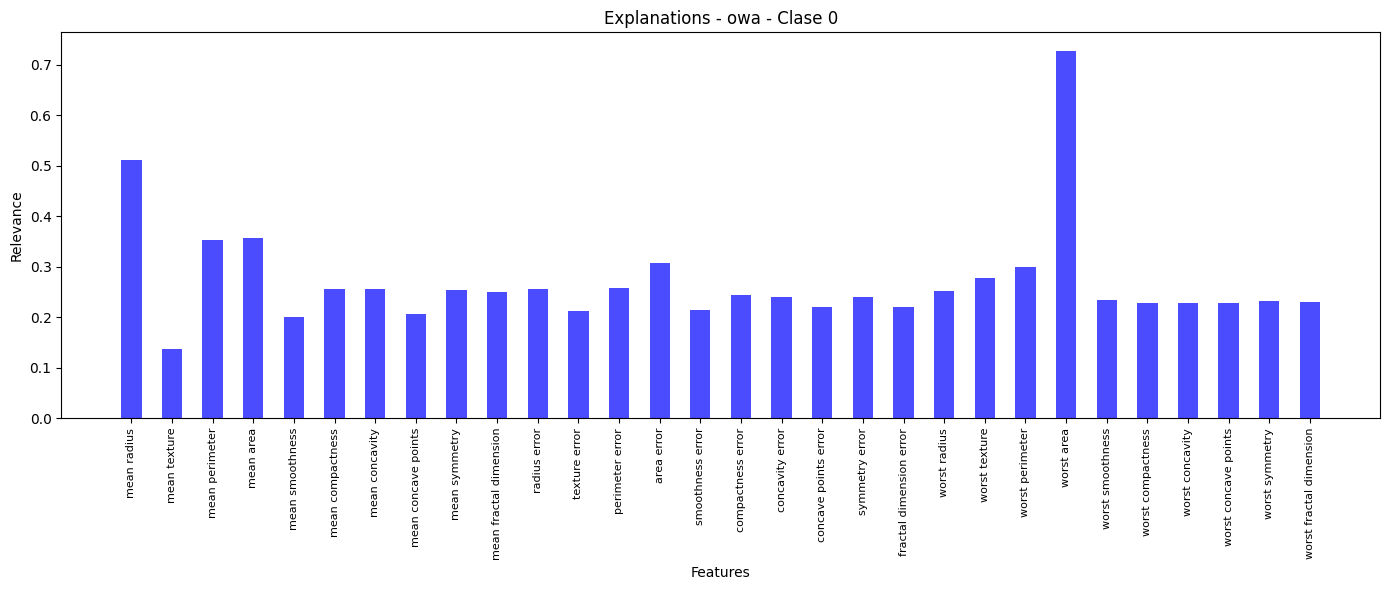

In [27]:
plot_explanation(owa_explanation_2, feature_names, "owa", predicted_class_index)

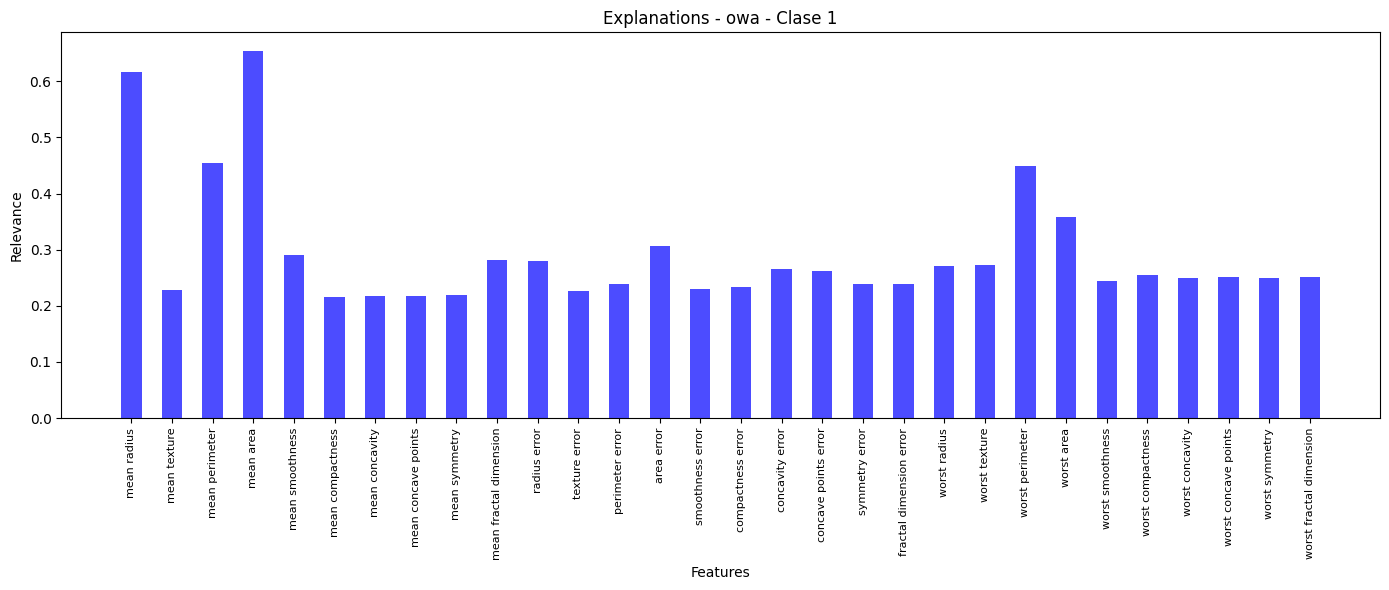

In [28]:
plot_explanation(owa_explanation_3, feature_names, "owa", predicted_class_index2)